In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import NMF as nmf #package
from all_func import gen_data, gdm, get_stat,gen_data_sparse# package
from numpy import array, dot
from qpsolvers import solve_qp
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import svds

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=Tru

In [2]:
#some useful functions
def objective_fn(y):
    def objective(x):
        return np.sum(y - x)
    return objective

# Define the L1 norm constraint
def constraint1(x):
    return np.sum(np.abs(x)) - 1

# Define the non-negative entries constraint
def constraint2(x):
    return x

def D_distance (H1, H2):

# This function computes the 'L'-distance between the two set of vectors collected in the rows of H1 and H2. In our paper notation, this is $\mathscr{L}(H_1, H_2)$.

    n1 = H1.shape[0]
    n2 = H2.shape[0]
    D = 0
    for i in range (0,n1):
        d = (np.linalg.norm(H1[i,:] - H2[0,:], ord=1))**2
        for j in range (1,n2):
            d = min(d, (np.linalg.norm(H1[i,:] - H2[j,:],ord=1)**2))
        D = D+d
    return D
def get_R(Xi):
    d=Xi.shape[0]
    K=Xi.shape[1]
    R=np.zeros((d,K-1))
    for k in range(0,K-1):
        R[:,k]=Xi[:,k+1]/Xi[:,0]
    
    return R
def svd_for_TM(X,r): #X here should be M0(-1/2)D
# This function computes the rank 'r' pca estimate of columns of 'X'.
    d=min(X.shape)
    if (r<d):
        K=r
    else:
        K=d
    U, s, V = np.linalg.svd(X)
    V=V[0:K,:]
    Xi = U[:,0:K]
    s = s[0:K]
    Xi[:,0]=np.abs(Xi[:,0])
    return [Xi,s,V]

def get_Pi(R,V_star):
    p=R.shape[0]
    K=V_star.shape[0]
    oneR=np.ones((p,1))
    oneV=np.ones((K,1))
    trueR=np.column_stack((oneR,R))
    Q=np.column_stack((oneV,V_star))
    Pi=np.matmul(trueR,np.linalg.inv(Q))
    return Pi
def get_hatA(Pi, Xi, M, sparse=False):

    hat_A_star=np.matmul(np.matmul(np.diag(M**(1/2)),np.diag(Xi[:,0])),Pi)
    temp=hat_A_star.sum(axis=0)
    hat_A=np.matmul(hat_A_star,np.diag(temp**(-1)))
    p=hat_A_star.shape[0]
    K=hat_A.shape[1]
    hat_A_sparse=np.zeros((p,K))
    if sparse:
        con1 = {'type': 'eq', 'fun': constraint1}
        con2 = {'type': 'ineq', 'fun': constraint2}
        cons = ([con1, con2])
        for k in range(0,K):
            y=hat_A_star[:,k]
            A_k_0=np.ones(p)/p
            b = (0, None)
            bnds = [b for i in range(len(A_k_0))]
            
            # Define the constraints
            # Solve the optimization problem
            solution=minimize(objective_fn(y), A_k_0, bounds=bnds, constraints=cons)
        
            hat_A_sparse[:,k] = solution.x
        temp=hat_A_sparse.sum(axis=0)
        hat_A=np.matmul(hat_A_sparse,np.diag(temp**(-1)))
    return hat_A


def get_W(A_hat,D):
    K = A_hat.shape[1]
    n = D.shape[1]
    W_hat = np.zeros((K, n))
    M = np.vstack((np.diag(np.ones(K-1)), np.repeat(-1, K-1)))

    bM = np.diag(np.ones(K))[:,K-1]
    Dmat = 2 * (A_hat @ M).T @ (A_hat @ M)
    Amat = M.T
    bvec = bM

    AM = A_hat @ M
    AbM = A_hat @ bM
    for i in range(0, n):
        dvec = 2 * (D[:,i] - AbM).T @ AM
    # Dmat = np.matrix(nearPD(Dmat)['mat'], nrow=Dmat.shape[0], ncol=Dmat.shape[1])
    # Dmat = nearPD(Dmat) min 1/2 x^T Dmat x + dvec^T x, S.t Amat.T x<= bvec
        qp_sol = solve_qp(Dmat, dvec, Amat.T, bvec, solver="osqp")
        #print(qp_sol)      
        W_hat[:,i] = np.concatenate((qp_sol, [1 - sum(qp_sol)]))
    W_hat = np.maximum(W_hat, 0)
    return W_hat


In [3]:
#Generate sample

np.random.seed(1)

V = 100000 # vocabulary size p (the final p is not necessary equal to V, will be less than this number because the condition sum up to one)
K = 3 # number of topics
M = 100 # number of documents n
Nm = 50 # words per document
eta = 0.5 # Dirichlet topic parameter #=0.1 means has anchor word assumption, larger value weaker anchor assumption
M_test = 250 # size of test set for perplexity comparison
alpha = np.repeat(0.1, K) # Dirichlet topic proportions parameter
gen_param = [V, K, M, Nm, eta, alpha, M_test]
eta_1=0.3
eta_2=3
s=1000
gen_param_sparse=[V, K, M, Nm, s,eta_1,eta_2, alpha, M_test]
#X, A, probW, simplex, anchor_set, theta_test, wdf_test = gen_data(*gen_param)
X, A, probW, simplex, anchor_set, theta_test, wdf_test = gen_data_sparse(*gen_param_sparse)
D=X.T
#wdf is D,beta_t=A,theta_t=W , simplex=WA where X=WA+Z

In [9]:
p=D.shape[0]
n=D.shape[1]
alpha_th=0.15
alpha_plus=0.005
N=Nm
pn=max(p,n)
tau=np.sqrt(np.log(pn)/(N*n))
TH_value=alpha_th*tau
M_value=D.mean(axis=1)/n 
#M=np.diag(M_value)
D_subset=D[M_value > TH_value,:]
print(D_subset.shape)
D_true=np.matmul(A.T,probW.T)
M_value_true=D_true.mean(axis=1)/n 
#M_true=np.diag(M_value_true)
D_true_subset=D[(M_value_true) > alpha_plus*tau,:]
print(D_true_subset.shape)
print(K/(alpha_plus*alpha_th*tau))

(3, 100)
(3, 100)
83358.93299732206


In [10]:
D.shape

(100000, 100)

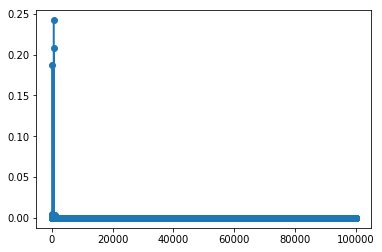

In [11]:
#show data of matrix A
data=A.T
row_norms = np.linalg.norm(data, ord=2, axis=1)
plt.plot(row_norms,marker='o')

In [27]:
np.sort(row_norms)[::-1][995:1005]

array([2.32352917e-04, 2.20327801e-04, 1.84034907e-04, 1.58772925e-04,
       1.50965842e-04, 5.74504395e-15, 5.73561482e-15, 5.59808448e-15,
       5.44377516e-15, 5.42486218e-15])

In [4]:
# algorithm with presvd
#algorithm 1 as in Ke
n=D.shape[1]
#do presvd
M_value=D.mean(axis=1)/n #rowmeans
MD=np.matmul(np.diag(M_value**(-1/2)),D)
[Xi,s,B]=svd_for_TM(MD,K) 
R=get_R(Xi)# is R
#vertex hunting using successive projections
start_time = time.time()
V_star=nmf.initH(R,K)
print("--- %s seconds ---" % (time.time() - start_time))
Pi=get_Pi(R,V_star)
hatA=get_hatA(Pi,Xi,M_value)
hatProbW=get_W(hatA,D)


--- 0.08449578285217285 seconds ---


C:\ProgramData\Anaconda3\lib\site-packages\qpsolvers\solvers\conversions\warnings.py:35: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  f"Converted {matrix_name} to scipy.sparse.csc.csc_matrix\n"
C:\ProgramData\Anaconda3\lib\site-packages\qpsolvers\solvers\conversions\warnings.py:35: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  f"Converted {matrix_name} to scipy.sparse.csc.csc_matrix\n"


In [20]:
#show error

print(np.linalg.norm(np.dot(hatA,hatProbW) - D))
print(np.sqrt(D_distance(hatA.T, A)))

108.24885130935193
0.6800899220755517


lambda =
0.001
Loss:
0.0
iter
2
Loss:
3.078927427123935
iter
3
Loss:
3.072250307619085
iter
4
Loss:
3.0439982934157843
iter
5
Loss:
3.025692127053327
iter
6
Loss:
2.9986323776076023
iter
7
Loss:
2.9470868559923065
iter
8
Loss:
2.8918362338344483
iter
9
Loss:
2.846105825164778
iter
10
Loss:
2.813561804726098
iter
11
Loss:
2.795311350601723
iter
12
Loss:
2.7906714460828006
iter
13
Loss:
2.797387517153381
iter
14
Loss:
2.8127898519834686
iter
15
Loss:
2.8351820486138677
iter
16
Loss:
2.8635822107564453
iter
17
Loss:
2.897526938918558
iter
18
Loss:
2.9367091843420874
iter
19
Loss:
2.9808525586050836
iter
20
Loss:
3.0296749705325685
iter
21
Loss:
3.083042787620636
iter
22
Loss:
3.140804985256473
iter
23
Loss:
3.2027833349268033
iter
24
Loss:
3.2687713470110165
iter
25
Loss:
3.3385354329033996
iter
26
Loss:
3.4118192985707436
iter
27
Loss:
3.4883454867096737
iter
28
Loss:
3.5678157815025346
iter
29
Loss:
3.6499114396079535
iter
30
Loss:
3.734294007779784
iter
31
Loss:
3.8206071853842634
iter

Loss:
5.222028617850854
iter
253
Loss:
5.222026590066101
iter
254
Loss:
5.22202456160734
iter
255
Loss:
5.222022532482393
iter
256
Loss:
5.2220205026989905
iter
257
Loss:
5.222018472264772
iter
258
Loss:
5.222016441187289
iter
259
Loss:
5.222014409474007
iter
260
Loss:
5.222012377132306
iter
261
Loss:
5.222010344169478
iter
262
Loss:
5.222008310592733
iter
263
Loss:
5.222006276409194
iter
264
Loss:
5.222004241625908
iter
265
Loss:
5.222002206249835
iter
266
Loss:
5.2220001702878545
iter
267
Loss:
5.221998133746771
iter
268
Loss:
5.221996096633306
iter
269
Loss:
5.221994058954105
iter
270
Loss:
5.221992020715735
iter
271
Loss:
5.22198998192469
iter
272
Loss:
5.221987942587387
iter
273
Loss:
5.221985902710167
iter
274
Loss:
5.221983862299304
iter
275
Loss:
5.221981821360992
iter
276
Loss:
5.221979779901358
iter
277
Loss:
5.221977737926455
iter
278
Loss:
5.221975695442268
iter
279
Loss:
5.2219736524547145
iter
280
Loss:
5.221971608969638
iter
281
Loss:
5.221969564992821
iter
282
Loss:
5.2

Loss:
5.221513985346297
iter
502
Loss:
5.2215119028731065
iter
503
Loss:
5.221509820364814
iter
504
Loss:
5.221507737821853
iter
505
Loss:
5.221505655244649
iter
506
Loss:
5.221503572633626
iter
507
Loss:
5.2215014899891985
iter
508
Loss:
5.221499407311781
iter
509
Loss:
5.2214973246017795
iter
510
Loss:
5.2214952418595955
iter
511
Loss:
5.221493159085631
iter
512
Loss:
5.221491076280276
iter
513
Loss:
5.22148899344392
iter
514
Loss:
5.221486910576947
iter
515
Loss:
5.221484827679737
iter
516
Loss:
5.221482744752666
iter
517
Loss:
5.221480661796105
iter
518
Loss:
5.22147857881042
iter
519
Loss:
5.221476495795976
iter
520
Loss:
5.221474412753129
iter
521
Loss:
5.221472329682236
iter
522
Loss:
5.221470246583643
iter
523
Loss:
5.2214681634577
iter
524
Loss:
5.221466080304746
iter
525
Loss:
5.221463997125123
iter
526
Loss:
5.221461913919162
iter
527
Loss:
5.221459830687194
iter
528
Loss:
5.221457747429547
iter
529
Loss:
5.221455664146541
iter
530
Loss:
5.221453580838499
iter
531
Loss:
5.22

Loss:
5.220997063093051
iter
750
Loss:
5.220994978122021
iter
751
Loss:
5.220992893151099
iter
752
Loss:
5.220990808180308
iter
753
Loss:
5.220988723209672
iter
754
Loss:
5.220986638239217
iter
755
Loss:
5.220984553268961
iter
756
Loss:
5.220982468298931
iter
757
Loss:
5.220980383329145
iter
758
Loss:
5.220978298359631
iter
759
Loss:
5.220976213390408
iter
760
Loss:
5.2209741284214966
iter
761
Loss:
5.22097204345292
iter
762
Loss:
5.2209699584847
iter
763
Loss:
5.220967873516856
iter
764
Loss:
5.220965788549411
iter
765
Loss:
5.220963703582384
iter
766
Loss:
5.220961618615792
iter
767
Loss:
5.220959533649662
iter
768
Loss:
5.2209574486840085
iter
769
Loss:
5.220955363718854
iter
770
Loss:
5.220953278754215
iter
771
Loss:
5.220951193790114
iter
772
Loss:
5.220949108826568
iter
773
Loss:
5.220947023863597
iter
774
Loss:
5.220944938901217
iter
775
Loss:
5.220942853939446
iter
776
Loss:
5.220940768978306
iter
777
Loss:
5.220938684017811
iter
778
Loss:
5.22093659905798
iter
779
Loss:
5.2209

iter
999
Loss:
5.220475857764972
iter
1000
Loss:
5.22047377316605
iter
1001
number of iterations:
1000
Final Loss in Estimating Archetypes:
5.22047377316605
lambda =
0.001623776739188721
Loss:
0.0
iter
2
Loss:
3.0789263905889968
iter
3
Loss:
3.0722483625428247
iter
4
Loss:
3.0439949255211345
iter
5
Loss:
3.0256869483837736
iter
6
Loss:
2.9986250275018356
iter
7
Loss:
2.9470769738170364
iter
8
Loss:
2.8918234447983013
iter
9
Loss:
2.8460897315024623
iter
10
Loss:
2.813542062730037
iter
11
Loss:
2.7952876760538032
iter
12
Loss:
2.790643593970846
iter
13
Loss:
2.7973552627876215
iter
14
Loss:
2.8127529644212212
iter
15
Loss:
2.8351402714890956
iter
16
Loss:
2.863535301874038
iter
17
Loss:
2.8974746508582214
iter
18
Loss:
2.9366512582030055
iter
19
Loss:
2.980788713846816
iter
20
Loss:
3.029604932744769
iter
21
Loss:
3.0829662740069668
iter
22
Loss:
3.140721701743659
iter
23
Loss:
3.2026929769980237
iter
24
Loss:
3.268673602070511
iter
25
Loss:
3.338429982294516
iter
26
Loss:
3.41170581912

Loss:
5.22141304261692
iter
248
Loss:
5.221409725954232
iter
249
Loss:
5.221406408486424
iter
250
Loss:
5.221403090222878
iter
251
Loss:
5.221399771172866
iter
252
Loss:
5.221396451345554
iter
253
Loss:
5.221393130750003
iter
254
Loss:
5.22138980939517
iter
255
Loss:
5.221386487289904
iter
256
Loss:
5.2213831644429565
iter
257
Loss:
5.2213798408629755
iter
258
Loss:
5.221376516558509
iter
259
Loss:
5.221373191538006
iter
260
Loss:
5.221369865809815
iter
261
Loss:
5.221366539382195
iter
262
Loss:
5.221363212263303
iter
263
Loss:
5.221359884461205
iter
264
Loss:
5.221356555983871
iter
265
Loss:
5.221353226839181
iter
266
Loss:
5.221349897034923
iter
267
Loss:
5.221346566578795
iter
268
Loss:
5.221343235478406
iter
269
Loss:
5.221339903741276
iter
270
Loss:
5.221336571374841
iter
271
Loss:
5.221333238386445
iter
272
Loss:
5.221329904783354
iter
273
Loss:
5.221326570572747
iter
274
Loss:
5.221323235761717
iter
275
Loss:
5.22131990035728
iter
276
Loss:
5.221316564366369
iter
277
Loss:
5.221

Loss:
5.220572262621703
iter
498
Loss:
5.220568881138468
iter
499
Loss:
5.220565499616814
iter
500
Loss:
5.220562118057249
iter
501
Loss:
5.220558736460281
iter
502
Loss:
5.220555354826407
iter
503
Loss:
5.220551973156124
iter
504
Loss:
5.220548591449916
iter
505
Loss:
5.220545209708269
iter
506
Loss:
5.220541827931657
iter
507
Loss:
5.220538446120552
iter
508
Loss:
5.2205350642754205
iter
509
Loss:
5.220531682396722
iter
510
Loss:
5.220528300484912
iter
511
Loss:
5.220524918540439
iter
512
Loss:
5.22052153656375
iter
513
Loss:
5.220518154555282
iter
514
Loss:
5.220514772515469
iter
515
Loss:
5.2205113904447416
iter
516
Loss:
5.220508008343526
iter
517
Loss:
5.220504626212237
iter
518
Loss:
5.220501244051293
iter
519
Loss:
5.2204978618611015
iter
520
Loss:
5.22049447964207
iter
521
Loss:
5.2204910973945955
iter
522
Loss:
5.2204877151190745
iter
523
Loss:
5.220484332815901
iter
524
Loss:
5.220480950485458
iter
525
Loss:
5.2204775681281275
iter
526
Loss:
5.220474185744289
iter
527
Loss:


Loss:
5.219726428027249
iter
748
Loss:
5.219723044366491
iter
749
Loss:
5.219719660709009
iter
750
Loss:
5.219716277054834
iter
751
Loss:
5.219712893403994
iter
752
Loss:
5.219709509756513
iter
753
Loss:
5.219706126112422
iter
754
Loss:
5.2197027424717435
iter
755
Loss:
5.2196993588345055
iter
756
Loss:
5.2196959752007315
iter
757
Loss:
5.219692591570448
iter
758
Loss:
5.21968920794368
iter
759
Loss:
5.219685824320452
iter
760
Loss:
5.219682440700788
iter
761
Loss:
5.219679057084714
iter
762
Loss:
5.219675673472251
iter
763
Loss:
5.219672289863425
iter
764
Loss:
5.219668906258257
iter
765
Loss:
5.219665522656772
iter
766
Loss:
5.219662139058993
iter
767
Loss:
5.219658755464942
iter
768
Loss:
5.21965537187464
iter
769
Loss:
5.21965198828811
iter
770
Loss:
5.219648604705373
iter
771
Loss:
5.219645221126452
iter
772
Loss:
5.219641837551368
iter
773
Loss:
5.219638453980141
iter
774
Loss:
5.219635070412793
iter
775
Loss:
5.219631686849342
iter
776
Loss:
5.219628303289809
iter
777
Loss:
5.21

Loss:
5.218977604862182
iter
998
Loss:
5.218972031713602
iter
999
Loss:
5.218966483887379
iter
1000
Loss:
5.218960961087333
iter
1001
number of iterations:
1000
Final Loss in Estimating Archetypes:
5.218960961087333
lambda =
0.0026366508987303583
Loss:
0.0
iter
2
Loss:
3.0789247074903647
iter
3
Loss:
3.072245204181575
iter
4
Loss:
3.043989456832565
iter
5
Loss:
3.0256785394220675
iter
6
Loss:
2.9986130926452046
iter
7
Loss:
2.947060927492408
iter
8
Loss:
2.891802678446589
iter
9
Loss:
2.8460635992645944
iter
10
Loss:
2.8135100065290786
iter
11
Loss:
2.7952492344156705
iter
12
Loss:
2.7905983690897953
iter
13
Loss:
2.7973028898637224
iter
14
Loss:
2.8126930685075666
iter
15
Loss:
2.835072436363706
iter
16
Loss:
2.8634591343307045
iter
17
Loss:
2.8973897492124365
iter
18
Loss:
2.936557202134735
iter
19
Loss:
2.980685047905965
iter
20
Loss:
3.029491211439768
iter
21
Loss:
3.082842038235353
iter
22
Loss:
3.1405864740980878
iter
23
Loss:
3.2025462631198574
iter
24
Loss:
3.2685148944896967
i

Loss:
5.220408185702254
iter
246
Loss:
5.2204027739232455
iter
247
Loss:
5.2203973611726875
iter
248
Loss:
5.220391947462001
iter
249
Loss:
5.220386532802475
iter
250
Loss:
5.220381117205268
iter
251
Loss:
5.2203757006814095
iter
252
Loss:
5.2203702832418
iter
253
Loss:
5.2203648648972125
iter
254
Loss:
5.220359445658301
iter
255
Loss:
5.220354025535589
iter
256
Loss:
5.220348604539482
iter
257
Loss:
5.220343182680266
iter
258
Loss:
5.220337759968105
iter
259
Loss:
5.220332336413048
iter
260
Loss:
5.220326912025024
iter
261
Loss:
5.220321486813851
iter
262
Loss:
5.220316060789234
iter
263
Loss:
5.220310633960757
iter
264
Loss:
5.220305206337907
iter
265
Loss:
5.22029977793005
iter
266
Loss:
5.220294348746447
iter
267
Loss:
5.22028891879625
iter
268
Loss:
5.220283488088512
iter
269
Loss:
5.220278056632173
iter
270
Loss:
5.220272624436073
iter
271
Loss:
5.220267191508951
iter
272
Loss:
5.22026175785944
iter
273
Loss:
5.220256323496081
iter
274
Loss:
5.220250888427306
iter
275
Loss:
5.220

Loss:
5.219041363817231
iter
496
Loss:
5.21903587520783
iter
497
Loss:
5.219030386559741
iter
498
Loss:
5.219024897873584
iter
499
Loss:
5.219019409149973
iter
500
Loss:
5.219013920389516
iter
501
Loss:
5.219008431592812
iter
502
Loss:
5.219002942760452
iter
503
Loss:
5.218997453893024
iter
504
Loss:
5.218991964991107
iter
505
Loss:
5.218986476055274
iter
506
Loss:
5.2189809870860895
iter
507
Loss:
5.218975498084112
iter
508
Loss:
5.2189700090498965
iter
509
Loss:
5.218964519983989
iter
510
Loss:
5.218959030886928
iter
511
Loss:
5.218953541759247
iter
512
Loss:
5.218948052601477
iter
513
Loss:
5.218942563414136
iter
514
Loss:
5.218937074197739
iter
515
Loss:
5.218931584952798
iter
516
Loss:
5.218926095679815
iter
517
Loss:
5.218920606379285
iter
518
Loss:
5.218915117051704
iter
519
Loss:
5.218909627697559
iter
520
Loss:
5.218904138317328
iter
521
Loss:
5.218898648911485
iter
522
Loss:
5.218893159480502
iter
523
Loss:
5.218887670024841
iter
524
Loss:
5.218882180544961
iter
525
Loss:
5.2

Loss:
5.217674385420922
iter
745
Loss:
5.217668896144285
iter
746
Loss:
5.217663406879524
iter
747
Loss:
5.217657917626672
iter
748
Loss:
5.2176524283857635
iter
749
Loss:
5.21764693915683
iter
750
Loss:
5.217641449939904
iter
751
Loss:
5.2176359607350165
iter
752
Loss:
5.2176304715422015
iter
753
Loss:
5.217624982361489
iter
754
Loss:
5.217619493192909
iter
755
Loss:
5.217614004036495
iter
756
Loss:
5.217608514892274
iter
757
Loss:
5.217603025760277
iter
758
Loss:
5.217597536640533
iter
759
Loss:
5.217592047533071
iter
760
Loss:
5.217586558437917
iter
761
Loss:
5.217581069355097
iter
762
Loss:
5.217575580284631
iter
763
Loss:
5.217570091226541
iter
764
Loss:
5.217564602180848
iter
765
Loss:
5.217559113147571
iter
766
Loss:
5.217553624126733
iter
767
Loss:
5.217548135118354
iter
768
Loss:
5.217542646122451
iter
769
Loss:
5.217537157139047
iter
770
Loss:
5.217531668168157
iter
771
Loss:
5.217526179209805
iter
772
Loss:
5.217520690264006
iter
773
Loss:
5.21751520133078
iter
774
Loss:
5.2

Loss:
5.116260627388721
iter
995
Loss:
5.115537001806466
iter
996
Loss:
5.114820726776934
iter
997
Loss:
5.114111093302256
iter
998
Loss:
5.1134073015263075
iter
999
Loss:
5.112708471320241
iter
1000
Loss:
5.1120136534686855
iter
1001
number of iterations:
1000
Final Loss in Estimating Archetypes:
5.1120136534686855


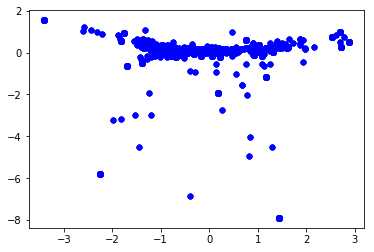

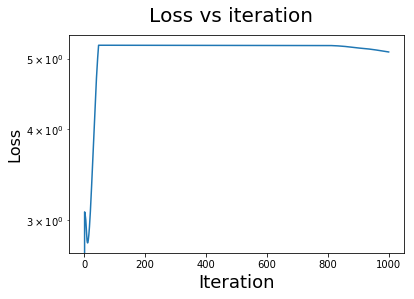

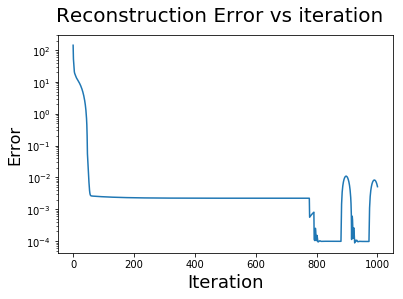

--- 364.14148235321045 seconds ---


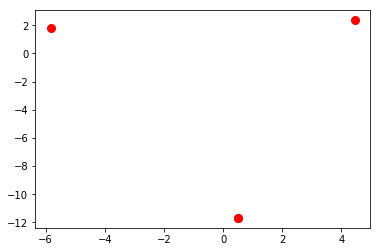

In [6]:
#algorithm 2
#vertex hunting using AA
start_time=time.time()
Pi2,V_star2, L, Err = nmf.acc_palm_nmf(R, r=K, proj_method='wolfe', m=5, maxiter=1000, c1 =1, c2 = 1, verbose = True, plotit = True, proj_low_dim = False, oracle = True, H0=V_star, weights_exact = False, method = 'fista', fixed_max_size=5)
print("--- %s seconds ---" % (time.time() - start_time))
hatA2=get_hatA(Pi2,Xi,M_value)
hatProbW2=get_W(hatA2,D)

In [7]:
hatA2=get_hatA(Pi2,Xi,M_value)
hatProbW2=get_W(hatA2,D)

In [19]:
#show error

print(np.linalg.norm(np.dot(hatA2,hatProbW2) - D))
print(np.sqrt(D_distance(hatA2.T, A)))

108.21702556598652
0.6815706817311283


In [9]:
D.shape

(3611, 100)

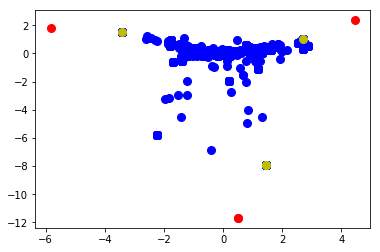

In [10]:
nmf.plot_H(R,"b","o")
nmf.plot_H(V_star2,"r","o")
nmf.plot_H(V_star,"y","o")


In [31]:
#algorithm 3 using thresholding and AA (as we claim in the paper) with presvd
# do thresholding 
p=D.shape[0]
n=D.shape[1]
alpha_th=0.15
N=Nm
TH_value=alpha_th*np.sqrt(np.log(p)/(N*n))
M_value=D.mean(axis=1)/n 
M=np.diag(M_value)
D_subset=D[np.diagonal(M) > TH_value]

MD=np.matmul(np.diag(M_value[M_value > TH_value]**(-1/2)),D_subset)

#with presvd
[Xi,s,B]=svd_for_TM(MD,K) 
R=get_R(Xi)# is R
#vertex hunting using AA
start_time=time.time()
Pi3,V_star3, L, Err = nmf.acc_palm_nmf(R, r=K, proj_method='wolfe', m=5, maxiter=1000, c1 =1, c2 = 1, verbose = True, plotit = True, proj_low_dim = False, oracle = True, H0=V_star, weights_exact = False, method = 'fista', fixed_max_size=5)
print("--- %s seconds ---" % (time.time() - start_time))


MemoryError: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64

In [17]:
one=np.ones(sum(1 for value in M_value if value >TH_value ))
hatA3_subset=get_hatA(Pi3,Xi,M_value[M_value>TH_value])
hatProbW3=get_W(hatA3_subset,D_subset)

In [18]:
#show error
hatD_Subset=np.dot(hatA3_subset,hatProbW3)
hatD3 = np.zeros((p, n))
hatD3[M_value > TH_value,:]=hatD_Subset
print(np.linalg.norm(hatD3 - D))
hatA3=np.zeros((A.T.shape[0], A.T.shape[1]))
hatA3[M_value > TH_value,:]=hatA3_subset
print(np.sqrt(D_distance(hatA3.T, A)))

105.00159214038105
0.43553843356038774


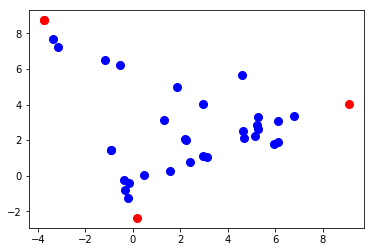

In [21]:
nmf.plot_H(R,"b","o")
nmf.plot_H(V_star3,"r","o")

In [35]:
#get V_star population version
D_true=np.matmul(A.T,probW.T)
M_value_true=D_true.mean(axis=1)/n 


#with presvd
[Xi_true,s_true,B_true]=svd_for_TM(D_true[M_value>TH_value,:],K) 
R_true=get_R(Xi_true)# is R

V_true=np.linalg.inv(Xi_true.T@ A[:,M_value>TH_value].T)
K=V_true.shape[1]
V_star_true=np.zeros((K,K-1))
for k in range(0,K-1):
    V_star_true[:,k]=V_true[:,k+1]/V_true[:,0]

lambda =
0.001
Loss:
3.0428769333323364
iter
2
Loss:
3.0428769333323364
iter
3
Loss:
2.718341131448821
iter
4
Loss:
2.6333308792620156
iter
5
Loss:
2.506627286800775
iter
6
Loss:
2.3496875759266507
iter
7
Loss:
2.212337814099611
iter
8
Loss:
2.1353957025117114
iter
9
Loss:
2.110779699040963
iter
10
Loss:
2.1124067585329755
iter
11
Loss:
2.113593006781427
iter
12
Loss:
2.1144687809172455
iter
13
Loss:
2.115129382346885
iter
14
Loss:
2.115642873483853
iter
15
Loss:
2.120067343359812
iter
16
Loss:
2.124442296104873
iter
17
Loss:
2.128637662142881
iter
18
Loss:
2.132534320958715
iter
19
Loss:
2.1360804635024384
iter
20
Loss:
2.1393003911897295
iter
21
Loss:
2.142269537003378
iter
22
Loss:
2.1450787392646204
iter
23
Loss:
2.1478057407452273
iter
24
Loss:
2.1505013778917506
iter
25
Loss:
2.153189325985279
iter
26
Loss:
2.1558740910728704
iter
27
Loss:
2.1585514424404213
iter
28
Loss:
2.161217028706913
iter
29
Loss:
2.1638711549699297
iter
30
Loss:
2.1665197035303376
iter
31
Loss:
2.169172440

Loss:
2.998339299706081
iter
310
Loss:
2.999259611870961
iter
311
Loss:
3.0001726826955646
iter
312
Loss:
3.001078548280478
iter
313
Loss:
3.001977244941852
iter
314
Loss:
3.0028688090095503
iter
315
Loss:
3.0037532766543955
iter
316
Loss:
3.0046306838332835
iter
317
Loss:
3.0055010663160466
iter
318
Loss:
3.0063644744752898
iter
319
Loss:
3.007185384987537
iter
320
Loss:
3.0079828899708065
iter
321
Loss:
3.0087775629170737
iter
322
Loss:
3.0095734747734357
iter
323
Loss:
3.010364240384483
iter
324
Loss:
3.0111480417080774
iter
325
Loss:
3.0119255145337847
iter
326
Loss:
3.012697008201759
iter
327
Loss:
3.0134624169357918
iter
328
Loss:
3.0142216474363006
iter
329
Loss:
3.0149747430975644
iter
330
Loss:
3.0157217775273213
iter
331
Loss:
3.0164628071582666
iter
332
Loss:
3.017197876809374
iter
333
Loss:
3.017927026877526
iter
334
Loss:
3.018650296368741
iter
335
Loss:
3.0193677243582924
iter
336
Loss:
3.0200793505024808
iter
337
Loss:
3.020785214772506
iter
338
Loss:
3.021485356946842
i

Loss:
2.912179434551342
iter
188
Loss:
2.9141235708382958
iter
189
Loss:
2.91605232437579
iter
190
Loss:
2.9179657621333424
iter
191
Loss:
2.9198639509598485
iter
192
Loss:
2.9217469575488955
iter
193
Loss:
2.9236148484076883
iter
194
Loss:
2.9254676898294476
iter
195
Loss:
2.9273055478690417
iter
196
Loss:
2.9291284883216893
iter
197
Loss:
2.9309365767045414
iter
198
Loss:
2.932729878240991
iter
199
Loss:
2.9345084578475844
iter
200
Loss:
2.9362723801233814
iter
201
Loss:
2.938021709341639
iter
202
Loss:
2.939756509443673
iter
203
Loss:
2.9414768440347743
iter
204
Loss:
2.943182776382043
iter
205
Loss:
2.944874369414034
iter
206
Loss:
2.9465516857220764
iter
207
Loss:
2.9482147875631703
iter
208
Loss:
2.949863736864347
iter
209
Loss:
2.951498595228396
iter
210
Loss:
2.9531194239408354
iter
211
Loss:
2.9547262839780624
iter
212
Loss:
2.956319236016561
iter
213
Loss:
2.957898340443097
iter
214
Loss:
2.959467109446748
iter
215
Loss:
2.9610235929406015
iter
216
Loss:
2.9625661146042894
it

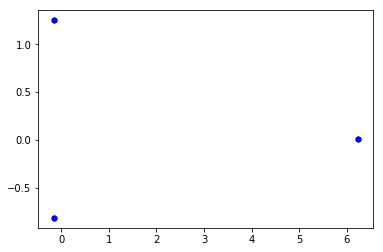

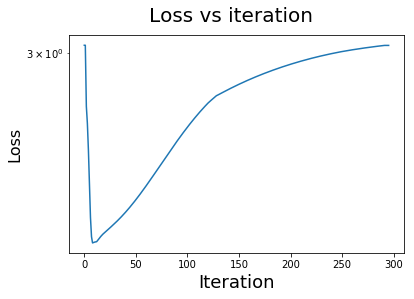

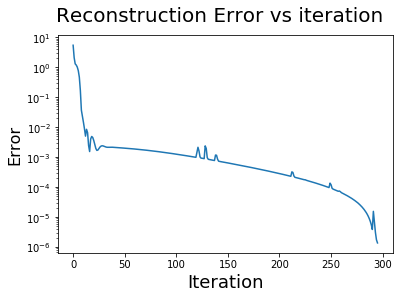

--- 28.85567593574524 seconds ---


C:\ProgramData\Anaconda3\lib\site-packages\qpsolvers\solvers\conversions\warnings.py:35: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  f"Converted {matrix_name} to scipy.sparse.csc.csc_matrix\n"
C:\ProgramData\Anaconda3\lib\site-packages\qpsolvers\solvers\conversions\warnings.py:35: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  f"Converted {matrix_name} to scipy.sparse.csc.csc_matrix\n"


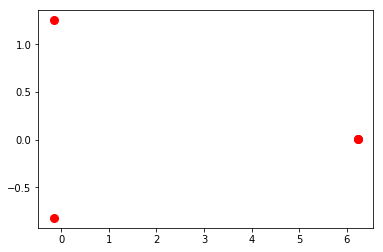

In [36]:
#algorithm 4
p=D.shape[0]
n=D.shape[1]
alpha_th=0.15
N=Nm
TH_value=alpha_th*np.sqrt(np.log(p)/(N*n))
M_value=D.mean(axis=1)/n 
D_subset=D[M_value > TH_value,]

#MD=np.matmul(np.diag(M_value[M_value > TH_value]**(-1/2)),D_subset)

#with presvd
[Xi,s,B]=svd_for_TM(D_subset,K) 
R=get_R(Xi)# is R
#vertex hunting using AA
start_time=time.time()
Pi3,V_star3, L, Err = nmf.acc_palm_nmf(R, r=K, proj_method='wolfe', m=5, maxiter=1000, c1 =1, c2 = 1, verbose = True, plotit = True,H0=V_star_true, proj_low_dim = False, oracle = True, weights_exact = False, method = 'fista', fixed_max_size=5)
print("--- %s seconds ---" % (time.time() - start_time))
one=np.ones(sum(1 for value in M_value if value >TH_value ))
hatA3_subset=get_hatA(Pi3,Xi,one)
hatProbW3=get_W(hatA3_subset,D_subset)



In [38]:
#show error
hatD_Subset=np.matmul(hatA3_subset,hatProbW3)
hatD4 = np.zeros((p, n))
hatD4[M_value > TH_value,:]=hatD_Subset
print(np.linalg.norm(hatD4 - D))
hatA4=np.zeros((A.T.shape[0], A.T.shape[1]))
hatA4[M_value > TH_value,:]=hatA3_subset
print(np.sqrt(D_distance(hatA4.T, A)))

119.71935486764826
2.7880623812166845


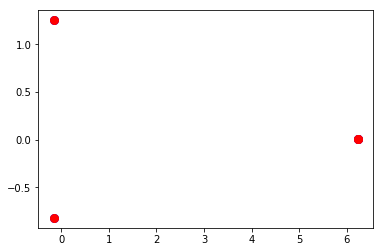

In [45]:
nmf.plot_H(R,"b","o")
nmf.plot_H(V_star3,"r","o")

In [40]:
np.linalg.norm(D - np.matmul(A.T,probW.T))

122.99405195838129

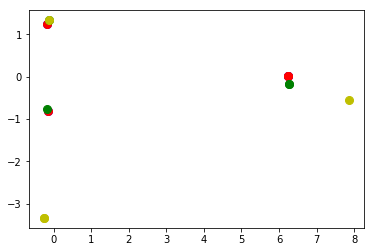

In [41]:
nmf.plot_H(R,"b","o")
nmf.plot_H(V_star3,"r","o")
nmf.plot_H(R_true,"g","o")
nmf.plot_H(V_star_true,"y","o")


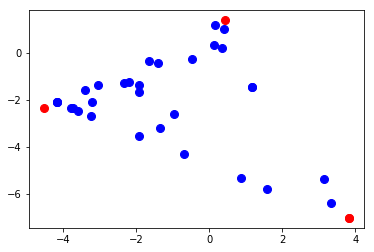

In [64]:
nmf.plot_H(R,"b","o")
nmf.plot_H(V_star3,"r","o")

In [61]:
D.shape

(3611, 100)

In [76]:
D_subset.shape

(3, 100)

In [73]:
print(np.sqrt(D_distance(hatA, A.T)))

0.36072869650800726


In [75]:
print(np.sqrt(D_distance(hatA4, A.T)))

0.5711434779249608


In [78]:
A.T

array([[6.79140448e-15, 5.11914671e-04, 6.69839626e-08],
       [6.32950842e-06, 2.35985168e-05, 1.99176376e-04],
       [5.30720285e-08, 1.37528213e-04, 3.71358575e-08],
       ...,
       [4.74055182e-05, 5.19504179e-05, 1.57929173e-12],
       [4.09235252e-13, 2.50795066e-04, 2.56873755e-06],
       [3.60049116e-04, 1.99964001e-04, 6.72163664e-07]])

In [79]:
TH_value

0.00607147676399643

In [80]:
D_true[M_value>TH_value,:].shape

(3, 100)

In [147]:
data=np.random.dirichlet(np.ones(1000)*0.5, 3).T

In [148]:
data[0:10,:]

array([[2.07511078e-05, 5.22821187e-06, 3.87594244e-03],
       [2.01617243e-03, 4.18069554e-03, 6.40285865e-04],
       [4.02437910e-03, 5.46731930e-05, 9.03059600e-04],
       [2.17139836e-03, 3.53599804e-05, 3.09020239e-03],
       [2.19801646e-03, 1.91056934e-04, 2.90883353e-03],
       [5.59410855e-06, 6.27838725e-04, 1.61017686e-04],
       [2.82362696e-03, 3.88078693e-03, 1.78218228e-03],
       [4.67362387e-05, 1.02658784e-03, 3.41261248e-04],
       [9.24470936e-04, 2.40647035e-03, 2.80957127e-04],
       [1.28913003e-04, 3.59722889e-05, 1.27735486e-04]])

In [149]:
row_norms = np.linalg.norm(data, ord=2, axis=1)

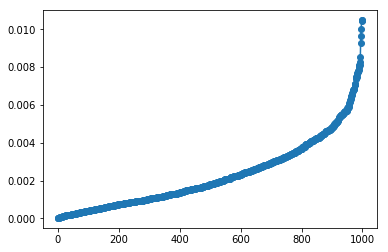

In [150]:
plt.plot(np.sort(row_norms),marker='o')

In [205]:
p = 10000  # Number of rows
K = 10  # Number of columns
s = 100  # Threshold value for distribution

# Generate matrix M with specified distribution
M = np.zeros((p, K))
M[0:s,:]=np.random.dirichlet(np.ones(s)*0.3, K).T
M[s:,:]=np.random.dirichlet(np.ones(p-s)*3, K).T*0.0001

# Perform Gram-Schmidt process to orthonormalize M


# Print the resulting matrix V
#print(np.abs(V))
M = np.apply_along_axis(lambda x: x/x.sum(), 1, np.abs(M).T)
M=M.T

In [206]:
np.linalg.matrix_rank(np.abs(M))

10

In [207]:
np.min(M[0:s,:])

1.9477423986631587e-12

In [208]:
M[95:105,:]

array([[3.77102438e-05, 1.98345530e-04, 5.01370488e-06, 6.26831600e-04,
        3.94477894e-02, 7.06810128e-06, 2.43494107e-04, 1.45303354e-02,
        4.05735508e-04, 3.74170478e-03],
       [1.26695365e-03, 5.26551648e-04, 1.30599425e-09, 4.42949502e-03,
        2.57447587e-03, 8.02736206e-06, 5.37755829e-02, 7.45695532e-03,
        1.42771303e-05, 1.17882744e-02],
       [1.43135415e-03, 4.79730435e-02, 1.49212931e-03, 2.41885815e-03,
        3.63462403e-04, 1.07637418e-02, 9.72488590e-03, 1.04647672e-05,
        1.42637362e-04, 1.72186714e-06],
       [2.54768994e-03, 1.99465920e-03, 8.41931612e-04, 2.35286093e-02,
        6.72171833e-04, 2.72668155e-02, 8.61367798e-03, 1.65797112e-02,
        2.65163121e-06, 3.35272405e-06],
       [6.06460249e-03, 1.39030295e-03, 6.43116874e-04, 5.08012607e-07,
        1.52328805e-02, 1.12453884e-07, 2.14899193e-03, 8.58738726e-04,
        4.05185854e-10, 3.81210689e-04],
       [1.19493792e-08, 7.35520949e-09, 8.73732976e-09, 5.02186588e-09,
   

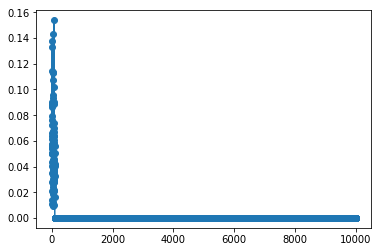

In [209]:
row_norms = np.linalg.norm(np.abs(M), ord=2, axis=1)
plt.plot(row_norms,marker='o')

In [210]:
np.min(row_norms)

1.5598563089818777e-08

In [211]:
print( np.linalg.norm(np.abs(M[0:10,:]), ord=2, axis=1))

[0.01412332 0.06412018 0.08818872 0.05654904 0.08640731 0.07648866
 0.05074018 0.0791881  0.04018166 0.09000785]


In [ ]:
print(M[90:95,:])

In [213]:
len(row_norms[row_norms>0.0001])

100

In [111]:
data=np.random.dirichlet(np.ones(10)*0.51, 3).T
data

array([[1.66805764e-01, 1.40305373e-02, 1.03012500e-01],
       [7.08735536e-03, 7.91597847e-02, 2.93484058e-02],
       [6.32605191e-02, 9.81335610e-02, 9.07590736e-02],
       [1.48789455e-03, 2.64821417e-02, 1.99835738e-01],
       [2.27251312e-04, 2.56360925e-01, 1.83652077e-04],
       [1.17357130e-01, 1.90432186e-02, 1.00969629e-01],
       [1.86483903e-01, 2.00522846e-03, 4.10668860e-01],
       [1.01161198e-02, 2.43847847e-01, 4.82271170e-02],
       [2.93808377e-01, 6.43314573e-02, 1.40964405e-03],
       [1.53365686e-01, 1.96605300e-01, 1.55853808e-02]])

In [112]:
np.linalg.norm(data,ord=2,axis=1)

array([0.19655176, 0.08472208, 0.14788272, 0.20158829, 0.25636109,
       0.15598143, 0.45103124, 0.24877693, 0.30077215, 0.24983511])

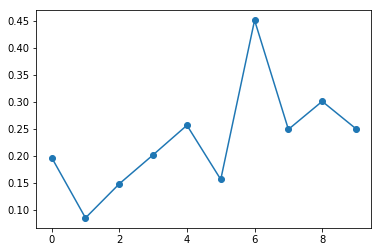

In [113]:
plt.plot(np.linalg.norm(data,ord=2,axis=1),marker='o')

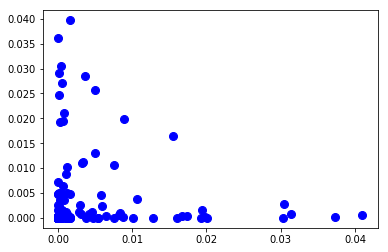

In [204]:
nmf.plot_H(M,'b','o')

In [4]:
np.random.normal(0,100,size=(10,3))

array([[-175.742067  ,   37.42662129,   59.07219339],
       [  72.64374975,   67.79741572,   72.19854158],
       [-201.64884636,  124.03363319,  -25.09195488],
       [-110.08108192,  120.53916938, -215.05947787],
       [ 169.14437002,   10.03454712,   24.33334058],
       [ -29.16798394,   10.54231666,  -70.79088164],
       [ -43.14057567,  -91.07424879,  152.45096716],
       [  54.47950264,    2.19211374,   29.71471583],
       [   2.7598028 ,   64.10403694,   68.67464146],
       [ 141.67541956, -129.90482829,   60.10464814]])